In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import string
import tensorflow as tf

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import GRU, LSTM, GlobalAveragePooling1D, Dense, TextVectorization, Input, Embedding, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [7]:
df = pd.read_csv("C:\\Users\\Asus\\Downloads\\IMDBdataset\\IMDB Dataset.csv"')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [10]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

# Mapping The Target Feature(Encoding)

In [11]:
df['sentiment'] = df['sentiment'].map({'positive': 1,'negative' :0 })


In [12]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Wordcloud

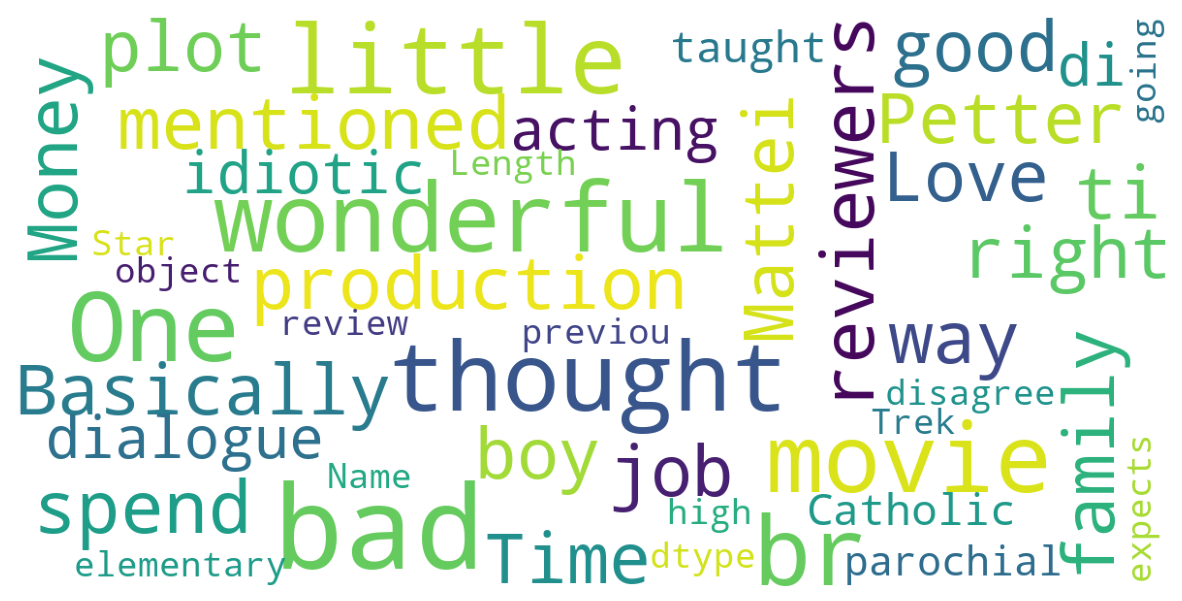

In [13]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df["review"])

# Text Vectorization and Adapting

In [14]:
txtVec = TextVectorization()

In [15]:
txtVec.adapt(df['review'])

In [16]:
txtVec(txtVec.get_vocabulary())

<tf.Tensor: shape=(182738, 1), dtype=int64, numpy=
array([[     0],
       [     1],
       [     2],
       ...,
       [182735],
       [182736],
       [182737]], dtype=int64)>

In [17]:
vocSize = txtVec.vocabulary_size()
vocSize

182738

In [18]:
txtVec(df['review']).numpy()

array([[  29,    5,    2, ...,    0,    0,    0],
       [   4,  385,  116, ...,    0,    0,    0],
       [  10,  195,   11, ...,    0,    0,    0],
       ...,
       [  10,  227,    4, ...,    0,    0,    0],
       [ 142,  162,    6, ...,    0,    0,    0],
       [  56,   29, 5827, ...,    0,    0,    0]], dtype=int64)

# Embedding + Modelling with GRU

In [19]:
netGRU = Sequential()

netGRU.add(Input(shape = (1, ), dtype = 'string'))
netGRU.add(txtVec)
netGRU.add(Embedding(vocSize, 2))
netGRU.add(GRU(32))
netGRU.add(Dropout(0.4))
netGRU.add(BatchNormalization())
netGRU.add(Dense(4, activation='relu'))
netGRU.add(Dense(1, activation = 'sigmoid'))

netGRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 2)           365476    
                                                                 
 gru (GRU)                   (None, 32)                3456      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 4)                 1

In [23]:
netGRU.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate=0.001))

earlyStoppingCallback = EarlyStopping(monitor = 'loss', patience = 1, restore_best_weights = True)


fitGRU = netGRU.fit(df['review'], df['sentiment'], batch_size=128, validation_split=0.2,
                  epochs = 20, callbacks = [earlyStoppingCallback])

Epoch 1/20
313/313 [==============================] - 218s 682ms/step - loss: 0.6934 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 2/20
313/313 [==============================] - 201s 642ms/step - loss: 0.6933 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4993
Epoch 3/20
313/313 [==============================] - 203s 649ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 4/20
313/313 [==============================] - 203s 646ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.4991
Epoch 5/20
313/313 [==============================] - 204s 653ms/step - loss: 0.6930 - accuracy: 0.5023 - val_loss: 0.6930 - val_accuracy: 0.4990
Epoch 6/20
313/313 [==============================] - 205s 656ms/step - loss: 0.6930 - accuracy: 0.5008 - val_loss: 0.6930 - val_accuracy: 0.4989
Epoch 7/20
313/313 [==============================] - 203s 650ms/step - loss: 0.6926 - accuracy: 0.4981 - val_loss: 0.6932 -

In [27]:
accFcn = fitGRU.history['accuracy']
valAccFcn = fitGRU.history['val_accuracy']
lossFcn = fitGRU.history['loss']
valLossFcn = fitGRU.history['val_loss']

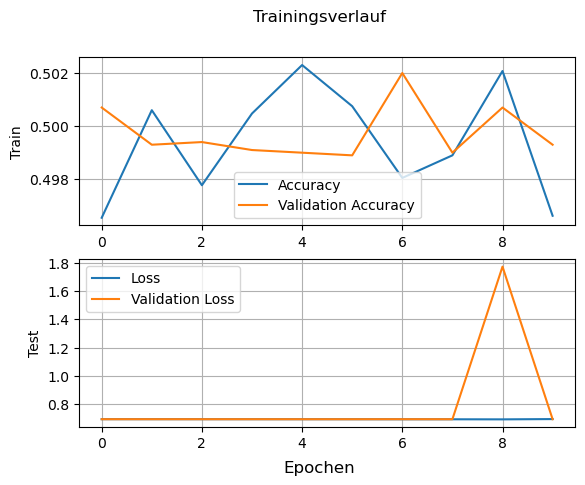

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("Trainingsverlauf")
fig.supxlabel("Epochen")

ax1.plot(accFcn, label = "Accuracy")
ax1.plot(valAccFcn, label = "Validation Accuracy")
ax1.set_ylabel('Train')
ax1.grid("on")
ax1.legend()

ax2.plot(lossFcn, label = "Loss")
ax2.plot(valLossFcn, label = "Validation Loss")
ax2.set_ylabel('Test')
ax2.grid("on")
ax2.legend()

plt.show()

# LSTM

In [29]:
netLSTM = Sequential()

netLSTM.add(Input(shape = (1, ), dtype = 'string'))
netLSTM.add(txtVec)
netLSTM.add(Embedding(vocSize, 2))
netLSTM.add(LSTM(8))
netLSTM.add(Dropout(0.4))
netLSTM.add(BatchNormalization())
netLSTM.add(Dense(4, activation='relu'))
netLSTM.add(Dense(1, activation = 'sigmoid'))

netLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 2)           365476    
                                                                 
 lstm (LSTM)                 (None, 8)                 352       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 batch_normalization_1 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 4)                

In [30]:
netLSTM.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate=0.001))

earlyStoppingCallback = EarlyStopping(monitor = 'loss', patience = 1, restore_best_weights = True)


fitLSTM = netLSTM.fit(df['review'], df['sentiment'], batch_size=128, validation_split=0.2,
                  epochs = 20, callbacks = [earlyStoppingCallback])

Epoch 1/20
313/313 [==============================] - 131s 403ms/step - loss: 0.6936 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.4993
Epoch 2/20
313/313 [==============================] - 122s 391ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 3/20
313/313 [==============================] - 127s 407ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 4/20
313/313 [==============================] - 129s 412ms/step - loss: 0.6931 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.4991
Epoch 5/20
313/313 [==============================] - 131s 419ms/step - loss: 0.6929 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.4989
Epoch 6/20
313/313 [==============================] - 133s 426ms/step - loss: 0.6924 - accuracy: 0.5034 - val_loss: 0.6930 - val_accuracy: 0.4989
Epoch 7/20
313/313 [==============================] - 124s 398ms/step - loss: 0.6937 - accuracy: 0.5094 - val_loss: 0.6932 -

In [31]:
accFcn = fitLSTM.history['accuracy']
valAccFcn = fitLSTM.history['val_accuracy']
lossFcn = fitLSTM.history['loss']
valLossFcn = fitLSTM.history['val_loss']

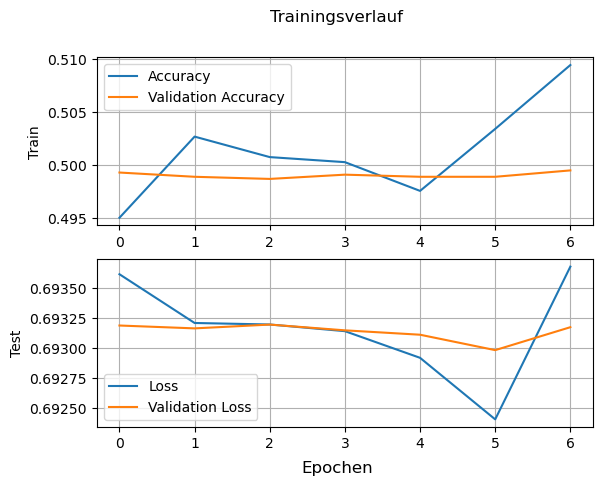

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("Trainingsverlauf")
fig.supxlabel("Epochen")

ax1.plot(accFcn, label = "Accuracy")
ax1.plot(valAccFcn, label = "Validation Accuracy")
ax1.set_ylabel('Train')
ax1.grid("on")
ax1.legend()

ax2.plot(lossFcn, label = "Loss")
ax2.plot(valLossFcn, label = "Validation Loss")
ax2.set_ylabel('Test')
ax2.grid("on")
ax2.legend()

plt.show()

# Global Average Pool

In [33]:
netGAP = Sequential()

netGAP.add(Input(shape=(1,), dtype = 'string'))
netGAP.add(txtVec)
netGAP.add(Embedding(vocSize, 2))
netGAP.add(GlobalAveragePooling1D())
netGAP.add(Dense(128, activation='relu'))
netGAP.add(Dropout(0.1))
netGAP.add(Dense(64, activation='relu'))
netGAP.add(Dropout(0.1))
netGAP.add(BatchNormalization())
netGAP.add(Dense(32, activation='relu'))
netGAP.add(Dropout(0.1))
netGAP.add(Dense(1, activation = 'sigmoid'))
netGAP.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, None, 2)           365476    
                                                                 
 global_average_pooling1d (  (None, 2)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_4 (Dense)             (None, 128)               384       
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [35]:
netGAP.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate=(1e-4)))

earlyStoppingCallback = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

fitGAP = netGAP.fit(df['review'], df['sentiment'], batch_size=128, validation_split=0.2, epochs = 2000, callbacks = [earlyStoppingCallback])

Epoch 1/2000
313/313 [==============================] - 15s 41ms/step - loss: 0.6848 - accuracy: 0.5904 - val_loss: 0.6858 - val_accuracy: 0.7528
Epoch 2/2000
313/313 [==============================] - 12s 37ms/step - loss: 0.5415 - accuracy: 0.7857 - val_loss: 0.4823 - val_accuracy: 0.8135
Epoch 3/2000
313/313 [==============================] - 12s 38ms/step - loss: 0.3523 - accuracy: 0.8599 - val_loss: 0.3437 - val_accuracy: 0.8545
Epoch 4/2000
313/313 [==============================] - 11s 35ms/step - loss: 0.2807 - accuracy: 0.8904 - val_loss: 0.3770 - val_accuracy: 0.8336
Epoch 5/2000
313/313 [==============================] - 12s 38ms/step - loss: 0.2408 - accuracy: 0.9079 - val_loss: 0.2947 - val_accuracy: 0.8796
Epoch 6/2000
313/313 [==============================] - 11s 35ms/step - loss: 0.2125 - accuracy: 0.9205 - val_loss: 0.3081 - val_accuracy: 0.8736
Epoch 7/2000
313/313 [==============================] - 12s 39ms/step - loss: 0.1861 - accuracy: 0.9327 - val_loss: 0.2965 -

In [36]:
accFcn = fitGAP.history['accuracy']
valAccFcn = fitGAP.history['val_accuracy']
lossFcn = fitGAP.history['loss']
valLossFcn = fitGAP.history['val_loss']

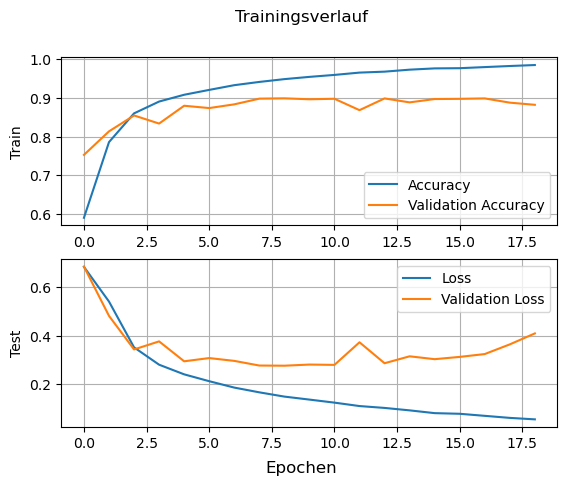

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("Trainingsverlauf")
fig.supxlabel("Epochen")

ax1.plot(accFcn, label = "Accuracy")
ax1.plot(valAccFcn, label = "Validation Accuracy")
ax1.set_ylabel('Train')
ax1.grid("on")
ax1.legend()

ax2.plot(lossFcn, label = "Loss")
ax2.plot(valLossFcn, label = "Validation Loss")
ax2.set_ylabel('Test')
ax2.grid("on")
ax2.legend()

plt.show()

In [38]:
txtVec.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'you',
 'are',
 'his',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'from',
 'who',
 'so',
 'like',
 'or',
 'just',
 'her',
 'about',
 'if',
 'has',
 'out',
 'some',
 'there',
 'what',
 'good',
 'when',
 'more',
 'very',
 'my',
 'even',
 'no',
 'up',
 'would',
 'she',
 'time',
 'only',
 'which',
 'really',
 'their',
 'see',
 'were',
 'story',
 'had',
 'can',
 'me',
 'than',
 'we',
 'much',
 'well',
 'been',
 'get',
 'will',
 'other',
 'do',
 'great',
 'also',
 'into',
 'bad',
 'because',
 'people',
 'how',
 'most',
 'first',
 'him',
 'dont',
 'then',
 'movies',
 'made',
 'them',
 'make',
 'films',
 'could',
 'any',
 'way',
 'too',
 'after',
 'characters',
 'think',
 'watch',
 'many',
 'seen',
 'being',
 'two',
 'character',
 'never',
 'love',
 'acting',
 'where',
 'did',
 'plot'

In [39]:
ypGRU = netGRU.predict(df['review'])
ypLSTM = netLSTM.predict(df['review'])
ypGAP = netGAP.predict(df['review'])

1563/1563 [==============================] - 17s 11ms/step


In [40]:
netGAP

In [41]:
print('GRU Model: ', ypGRU[0])
print('LSTM Model: ' , ypLSTM[0])
print('GAP Model: ' , ypGAP[0])

GRU Model:  [0.9703546]
LSTM Model:  [0.49812365]
GAP Model:  [0.9888841]


In [43]:
netGAP.save('movie_review.tf', 'tf')

INFO:tensorflow:Assets written to: movie_review.tf\assets


INFO:tensorflow:Assets written to: movie_review.tf\assets
